<a href="https://colab.research.google.com/github/JAMES-YI/00_Python_Tutorial/blob/master/Lab_03_v2_solu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 03 version 2 for ECE 5995: Foundations of deep learning

Outlines

(1) Train CNN for MNIST dataset

(2) Design targeted and untargeted attacks for the trained CNN

(3) Perform adversarial training for defense attacks

Codes from: https://github.com/souravsingh/mnist-adversarial-attack

Modified by JYI, 11/16/2019

Last updated by JYI, 12/06/2019

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

#Read the input data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Model construction - I

x = tf.keras.backend.placeholder(shape=[None, 784], dtype=tf.float32)
y_ = tf.keras.backend.placeholder(shape=[None, 10], dtype=tf.float32)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.keras.backend.conv2d(x, W, strides=(1, 1), padding='same')

def max_pooling_2x2(x):
    return tf.keras.backend.pool2d(x, pool_size=(2,2), strides=(2,2), padding='same')

In [0]:
# Model construction - II

x_image = tf.reshape(x, [-1,28,28,1])

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

y = tf.nn.softmax(y_conv)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  1%|          | 12/1000 [00:00<02:20,  7.04it/s]

step 0, training accuracy 0.1


 22%|██▏       | 215/1000 [00:02<00:07, 107.05it/s]

step 200, training accuracy 0.87


 42%|████▏     | 417/1000 [00:04<00:05, 112.62it/s]

step 400, training accuracy 0.96


 62%|██████▏   | 618/1000 [00:05<00:03, 106.39it/s]

step 600, training accuracy 0.94


 82%|████████▏ | 818/1000 [00:07<00:01, 108.65it/s]

step 800, training accuracy 0.96


100%|██████████| 1000/1000 [00:09<00:00, 106.57it/s]


Final test accuracy 0.97
Final train accuracy 0.964


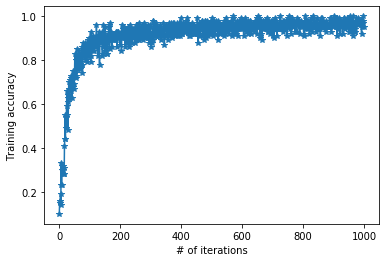

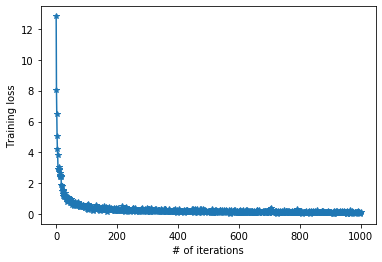

In [31]:
# Classifier training


# (1) Train a classifier, and plot its training loss and training accuracy
import matplotlib.pyplot as plt

train_accuracy_list = []
cross_entropy_val_list = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    cross_entropy_val = cross_entropy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    train_accuracy_list.append(train_accuracy)
    cross_entropy_val_list.append(cross_entropy_val)
    if i%200 == 0:
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})
  
print("Final test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))
print("Final train accuracy %g"%accuracy.eval(feed_dict={x: mnist.train.images[0:500], 
                                                  y_: mnist.train.labels[0:500], keep_prob: 1.0}))
plt.figure()
plt.plot(train_accuracy_list,'-*')
plt.xlabel('# of iterations')
plt.ylabel('Training accuracy')
plt.show()

plt.figure()
plt.plot(cross_entropy_val_list,'-*')
plt.xlabel('# of iterations')
plt.ylabel('Training loss')
plt.show()



In [32]:
# Adversarial attacks
# (2) Untargeted attack: only take 10 samples of digit 3 for demonstration, we do not specify the target labels

index_of_oc = np.nonzero(mnist.test.labels[0:500][:,3])[0][0:10]
x_batch = mnist.test.images[index_of_oc]
y_batch = mnist.test.labels[index_of_oc]
prediction = tf.argmax(y,1)
prediction_val_naa = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
probabilities = y
probabilities_val_naa = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)

target_number = 3
target_labels = np.zeros((10, 10))
target_labels[:, target_number] = 1
img_gradient = tf.gradients(cross_entropy, x)[0]
step_size = 0.03
steps = 10

adversarial_img = x_batch.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
print('Correct label', np.argmax(y_batch,axis=1))
print('Predicted label and confidence before attacking:')
print(set(zip(prediction_val_naa,np.max(probabilities_val_naa,axis=1))))
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    adversarial_img = adversarial_img + step_size * np.sign(gradient)
    adversarial_img = np.clip(adversarial_img, a_min=0, a_max=1)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val_aa = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    probabilities = y
    probabilities_val_aa = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print(f"Step: {i}")
    print('Predicted label and confidence after attacking:')
    print(set(zip(prediction_val_aa,np.max(probabilities_val_aa,axis=1))))

prob2_hist.append(probabilities_val_aa[:,2])
prob6_hist.append(probabilities_val_aa[:,6])

Correct label [3 3 3 3 3 3 3 3 3 3]
Predicted label and confidence before attacking:
{(3, 0.5689567), (3, 0.99974066), (3, 0.9996449), (3, 0.9962458), (3, 0.9761179), (3, 0.91667706), (3, 0.9984175), (3, 0.9950761), (3, 0.9831572), (3, 0.99797267)}
Step: 0
Predicted label and confidence after attacking:
{(3, 0.9972941), (3, 0.99376065), (3, 0.9679347), (8, 0.7121634), (3, 0.8947624), (3, 0.4965285), (3, 0.97942036), (3, 0.9625036), (3, 0.89982724), (3, 0.9827958)}
Step: 1
Predicted label and confidence after attacking:
{(3, 0.96803993), (3, 0.92694974), (3, 0.79057306), (8, 0.88919216), (3, 0.6054796), (3, 0.7804421), (3, 0.76361585), (3, 0.55166036), (3, 0.87413824), (2, 0.9101797)}
Step: 2
Predicted label and confidence after attacking:
{(3, 0.7622032), (3, 0.5430742), (8, 0.960727), (8, 0.79756176), (2, 0.9868749), (5, 0.50678027), (5, 0.6554411), (5, 0.70843154), (5, 0.73697615), (1, 0.41878748)}
Step: 3
Predicted label and confidence after attacking:
{(8, 0.9801793), (8, 0.9680908

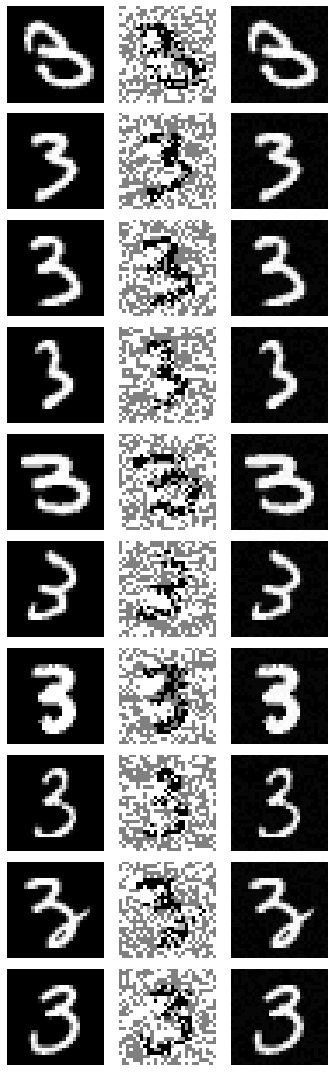

In [33]:
# Results visualization for untargeted attack
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(x_batch[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - x_batch[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()

In [34]:
# Adversarial attacks
# (3) targeted attack: we take 10 samples of digit 3 for demonstration, and the target label is specified as 7
index_of_oc = np.nonzero(mnist.test.labels[0:500][:,3])[0][0:10]
x_batch = mnist.test.images[index_of_oc]
y_batch = mnist.test.labels[index_of_oc]
prediction = tf.argmax(y,1)
prediction_val_naa = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
probabilities = y
probabilities_val_naa = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)

target_number = 7
target_labels = np.zeros((10, 10))
target_labels[:, target_number] = 1
img_gradient = tf.gradients(cross_entropy, x)[0]
step_size = 0.03
steps = 10

adversarial_img = x_batch.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
print('Correct label', np.argmax(y_batch,axis=1))
print('Predicted label and confidence before attacking:')
print(set(zip(prediction_val_naa,np.max(probabilities_val_naa,axis=1))))
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    adversarial_img = adversarial_img - step_size * np.sign(gradient)
    adversarial_img = np.clip(adversarial_img, a_min=0, a_max=1)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val_aa = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    probabilities = y
    probabilities_val_aa = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print(f"Step: {i}")
    print('Predicted label and confidence after attacking:')
    print(set(zip(prediction_val_aa,np.max(probabilities_val_aa,axis=1))))

prob2_hist.append(probabilities_val_aa[:,2])
prob6_hist.append(probabilities_val_aa[:,6])

Correct label [3 3 3 3 3 3 3 3 3 3]
Predicted label and confidence before attacking:
{(3, 0.5689567), (3, 0.99974066), (3, 0.9996449), (3, 0.9962458), (3, 0.9761179), (3, 0.91667706), (3, 0.9984175), (3, 0.9950761), (3, 0.9831572), (3, 0.99797267)}
Step: 0
Predicted label and confidence after attacking:
{(3, 0.4191375), (3, 0.9986552), (3, 0.9978759), (3, 0.98661673), (3, 0.92785364), (3, 0.757282), (3, 0.99120647), (3, 0.9797544), (3, 0.9127521), (3, 0.9921582)}
Step: 1
Predicted label and confidence after attacking:
{(3, 0.4129181), (3, 0.9904793), (3, 0.98723745), (3, 0.9590444), (3, 0.71781945), (3, 0.52334625), (3, 0.9631768), (3, 0.9184349), (3, 0.61164105), (3, 0.97303694)}
Step: 2
Predicted label and confidence after attacking:
{(7, 0.36275306), (7, 0.4691219), (7, 0.83147836), (3, 0.9069161), (3, 0.93553686), (3, 0.82871807), (3, 0.47539946), (3, 0.81483394), (3, 0.74271107), (3, 0.907571)}
Step: 3
Predicted label and confidence after attacking:
{(7, 0.7260907), (7, 0.8123196)

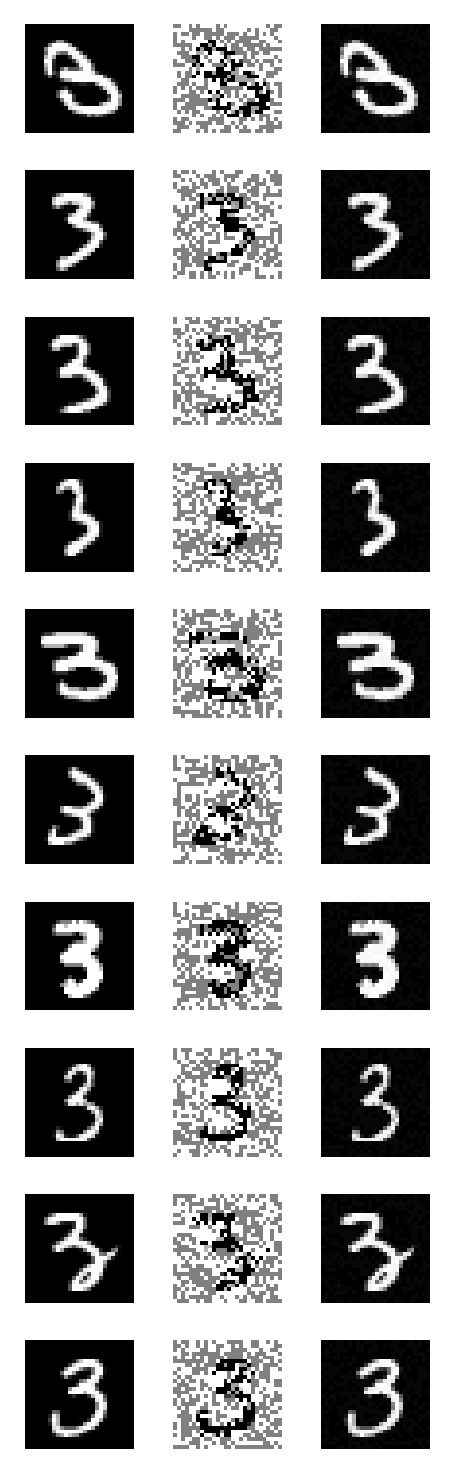

In [35]:
# Results visualization for the targeted attack case
f, axarr = plt.subplots(10, 3, figsize=(2,6))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(x_batch[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - x_batch[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()

In [37]:
# (4) perform targeted attack for testing samples
# It can take pretty long time: 100 seconds for generating 1000 adversarial samples
# We only take samples from class 0 for demonstration

import time

AdvSample = [] # for storing all the adversarial samples

for lab_ori in np.arange(0,1):
  # visit samples in each class
  # 
  index_of_oc = np.nonzero(mnist.test.labels[:,lab_ori])[0] # all the samples in class lab_ori; lab_ori means the true label
  x_batch = mnist.test.images[index_of_oc]
  y_batch = mnist.test.labels[index_of_oc]
  SampleNumSub = len(index_of_oc)

  lab_tar_list = [lab for lab in np.arange(0,10) if lab!=lab_ori]

  # prediction_val_naa = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
  # probabilities_val_naa = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
  
  for lab_tar in lab_tar_list:
    # generate adversarial samples that can be misclassified as in each class
    print(f"Attack samples in class {lab_ori} to be misclassified as class {lab_tar}\n")
    target_number = lab_tar
    target_labels = np.zeros((1, 10))
    target_labels[:, target_number] = 1
    img_gradient = tf.gradients(cross_entropy, x)[0]
    step_size = 0.03
    steps = 20 # if we cannot find an adversarial sample within 20 iterations, then we treat the attack as a failure and we stop
    
    start = time.time()
    samp_ind_vec = np.arange(SampleNumSub)
    for samp_ind in samp_ind_vec:
      # every time, attack one sample
      x_sample = x_batch[samp_ind]
      adversarial_img = x_sample.copy().reshape((1,784))
      prediction = tf.argmax(y,1)
      Iter = 0
      while Iter<steps:

          gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
          adversarial_img = adversarial_img - step_size * np.sign(gradient)
          adversarial_img = np.clip(adversarial_img, a_min=0, a_max=1)
          if prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess) == lab_tar:
            # print(f"Attack success\n")
            AdvSample.append(adversarial_img)
            break
          Iter = Iter+1
    print(f"Elapsed time for generating {SampleNumSub} adversarial samples: {time.time() - start}\n")

Attack samples in class 0 to be misclassified as class 1

Elapsed time for generating 980 adversarial samples: 93.66795778274536

Attack samples in class 0 to be misclassified as class 2

Elapsed time for generating 980 adversarial samples: 117.44662594795227

Attack samples in class 0 to be misclassified as class 3

Elapsed time for generating 980 adversarial samples: 150.5247585773468

Attack samples in class 0 to be misclassified as class 4

Elapsed time for generating 980 adversarial samples: 181.9219410419464

Attack samples in class 0 to be misclassified as class 5

Elapsed time for generating 980 adversarial samples: 209.68371081352234

Attack samples in class 0 to be misclassified as class 6

Elapsed time for generating 980 adversarial samples: 239.8090524673462

Attack samples in class 0 to be misclassified as class 7

Elapsed time for generating 980 adversarial samples: 281.1859838962555

Attack samples in class 0 to be misclassified as class 8

Elapsed time for generating 98

In [38]:
# (4) test prediction accuracy over adversarial samples
Adv = np.concatenate(AdvSample,axis=0)
LabPred = prediction.eval(feed_dict={x: Adv, keep_prob: 1.0}, session=sess)
AccAdv = np.mean(LabPred==0)
print(f'Testing accuracy on adversarial samples {AccAdv}')


Testing accuracy on adversarial samples 0.00045351473922902497


In [0]:
# (5) perform targeted attack on training samples
# It can take pretty long time: 100 seconds for generating 1000 adversarial samples
# We only take samples from class 0 for demonstration

import time

AdvSampleTrain = [] # for storing all the adversarial samples

for lab_ori in np.arange(0,1):
  # visit samples in each class
  # here we
  index_of_oc = np.nonzero(mnist.train.labels[:,lab_ori])[0] # all the samples in class lab_ori; lab_ori means the true label
  x_batch = mnist.train.images[index_of_oc]
  y_batch = mnist.train.labels[index_of_oc]
  SampleNumSub = len(index_of_oc)

  lab_tar_list = [lab for lab in np.arange(0,10) if lab!=lab_ori]

  # prediction_val_naa = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
  # probabilities_val_naa = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
  
  for lab_tar in lab_tar_list:
    # generate adversarial samples that can be misclassified as in each class
    print(f"Attack samples in class {lab_ori} to be misclassified as class {lab_tar}\n")
    target_number = lab_tar
    target_labels = np.zeros((1, 10))
    target_labels[:, target_number] = 1
    img_gradient = tf.gradients(cross_entropy, x)[0]
    step_size = 0.03
    steps = 20 # if we cannot find an adversarial sample within 20 iterations, then we treat the attack as a failure and we stop
    
    start = time.time()
    samp_ind_vec = np.arange(SampleNumSub)
    for samp_ind in samp_ind_vec:
      # every time, attack one sample
      x_sample = x_batch[samp_ind]
      adversarial_img = x_sample.copy().reshape((1,784))
      prediction = tf.argmax(y,1)
      Iter = 0
      while Iter<steps:

          gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
          adversarial_img = adversarial_img - step_size * np.sign(gradient)
          adversarial_img = np.clip(adversarial_img, a_min=0, a_max=1)
          if prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess) == lab_tar:
            # print(f"Attack success\n")
            AdvSampleTrain.append(adversarial_img)
            break
          Iter = Iter+1
    print(f"Elapsed time for generating {SampleNumSub} adversarial samples: {time.time() - start}\n")

In [41]:
# Evaluate the prediction performance over adversarial samples generated from training data
AdvTrain = np.concatenate(AdvSampleTrain,axis=0)
LabPred = prediction.eval(feed_dict={x: AdvTrain, keep_prob: 1.0}, session=sess)
AccAdv = np.mean(LabPred==0)
print(f'Testing accuracy on adversarial samples {AccAdv}')

Testing accuracy on adversarial samples 0.0002281021897810219


In [48]:
# (5) retrain classifier with adversarial training samples
AdvTrainLab = np.zeros((len(AdvTrain), 10))
AdvTrainLab[:,0] = 1
advtrain_accuracy_list = []
advcross_entropy_val_list = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
batch_size = 100
batch_num = int(len(AdvTrain)/batch_size)
for i in np.arange(10):
  # training for 10 epochs
  Index = np.random.permutation(len(AdvTrain))
  AdvTrain = AdvTrain[Index]

  for j in np.arange(batch_num):
    xbatch = AdvTrain[j*batch_size:((j+1)*batch_size)]
    ybatch = AdvTrainLab[j*batch_size:((j+1)*batch_size)]
    train_accuracy = accuracy.eval(feed_dict={x:xbatch, y_: ybatch, keep_prob: 1.0})
    cross_entropy_val = cross_entropy.eval(feed_dict={x:xbatch, y_: ybatch, keep_prob: 1.0})
    
    if j%200 == 0:
        print(f"Epoch {i+1}/{10}, batch {j+1}/{batch_num}, training accuracy {train_accuracy}\n")

    train_step.run(feed_dict={x:xbatch, y_: ybatch, keep_prob: 0.4})
  
  advtrain_accuracy_list.append(train_accuracy)
  advcross_entropy_val_list.append(cross_entropy_val)
  

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1/10, batch 1/87, training accuracy 0.0

Epoch 2/10, batch 1/87, training accuracy 1.0

Epoch 3/10, batch 1/87, training accuracy 1.0

Epoch 4/10, batch 1/87, training accuracy 1.0

Epoch 5/10, batch 1/87, training accuracy 1.0

Epoch 6/10, batch 1/87, training accuracy 1.0

Epoch 7/10, batch 1/87, training accuracy 1.0

Epoch 8/10, batch 1/87, training accuracy 1.0

Epoch 9/10, batch 1/87, training accuracy 1.0

Epoch 10/10, batch 1/87, training accuracy 1.0



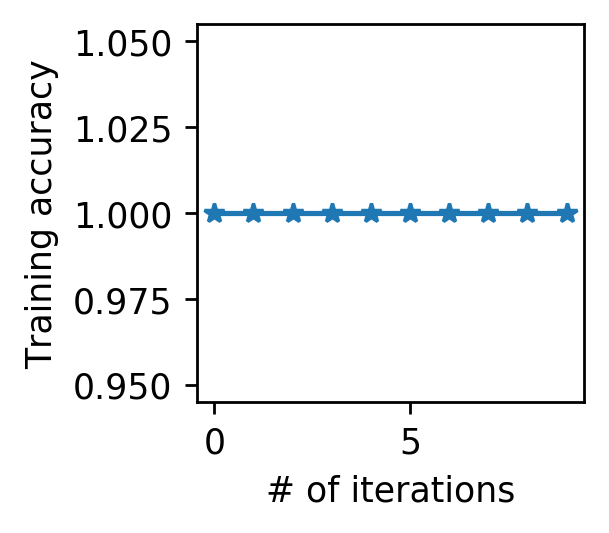

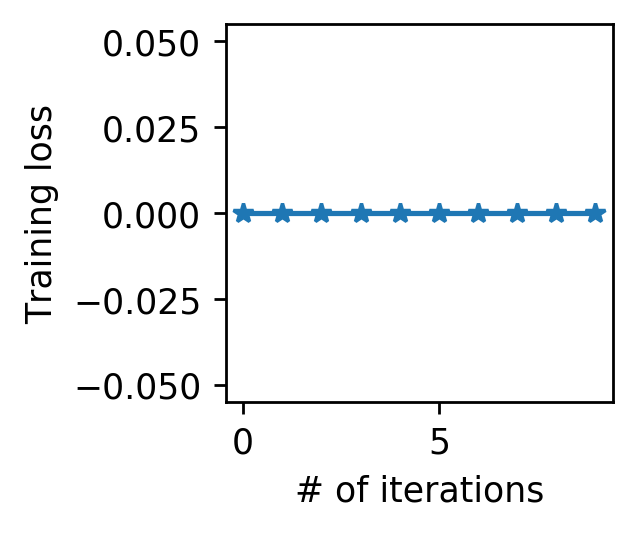

In [49]:
# Plot the training loss and accuracy over adversarial samples
plt.figure(figsize=(2,2))
plt.plot(advtrain_accuracy_list,'-*')
plt.xlabel('# of iterations')
plt.ylabel('Training accuracy')
plt.show()

plt.figure(figsize=(2,2))
plt.plot(advcross_entropy_val_list,'-*')
plt.xlabel('# of iterations')
plt.ylabel('Training loss')
plt.show()

In [50]:
# Evaluate the prediction performance over adversarial samples generated from training data
LabPred = prediction.eval(feed_dict={x: Adv, keep_prob: 1.0}, session=sess)
AccAdv = np.mean(LabPred==0)
print(f'Testing (adversarial) accuracy on adversarial samples {AccAdv}')

LabPred = prediction.eval(feed_dict={x: AdvTrain, keep_prob: 1.0}, session=sess)
AccAdv = np.mean(LabPred==0)
print(f'Training (adversarial) accuracy on adversarial samples {AccAdv}')


Testing (adversarial) accuracy on adversarial samples 1.0
Training (adversarial) accuracy on adversarial samples 1.0
